# EDA of Ship Images Dataset

This notebook consists of the EDA of the training data given

In [112]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set_theme()
import glob     
import numpy as np
from PIL import Image
from collections import Counter

In [217]:
TRAIN_SAMPLES = len(glob.glob("train_data/*.jpg"))

# Train Data Statistics

The filename is test_labels.csv, however, with the lack of test samples, it would make sense that this was     meant to be the training labels
train_labels_df
            image  category
0     2810798.jpg         0
1     2818929.jpg         0
2     2856024.jpg         0
3     2878219.jpg         0
4     2841647.jpg         0
...           ...       ...
1995  2858050.jpg         4
1996  2886392.jpg         4
1997  2816858.jpg         4
1998  2845755.jpg         4
1999  2872187.jpg         4

[2000 rows x 2 columns]


Classes: [0 1 2 3 4]
Number of unique train labels: 2000


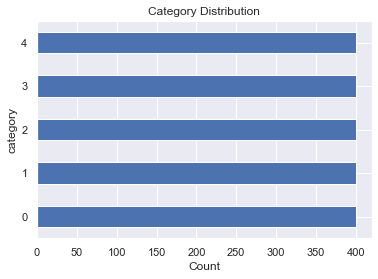

Number of train samples: 1000
Number of train labels: 2000
Print true if training_labels equate to the number of training samples:
False


There is a discrepancy in the training samples given and the 'test' labels in our csv. As such from this point on, we will only consider the subset distribution of the intersection of     both the training data dataframe and the training label dataframe as our complete training data


Train data
           image
0    1010906.jpg
1    1098729.jpg
2    1124945.jpg
3    1124951.jpg
4    1131196.jpg
..           ...
995   907105.jpg
996   921003.jpg
997   929280.jpg
998   929533.jpg
999   950585.jpg

[1000 rows x 1 columns]
intersection df
           image  category
0    2810798.jpg         0
1    2818929.jpg         0
2    2856024.jpg         0
3    2878219.jpg         0
4    2841647.jpg         0
..           ...       ...
995  2835366.jpg         4
996  2792391.jpg         4
997  2902617.jpg         4
998  2894578.jpg         4
999  2900652.jpg      

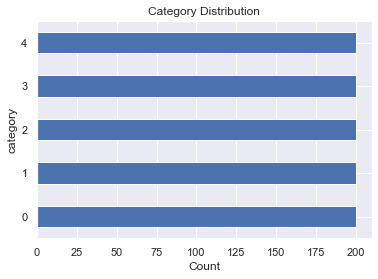

Since, the categories of the training set are equally distributed, a sampling strategy for training is not needed due to the lack of minority of and majority classes


In [73]:
print("The filename is test_labels.csv, however, with the lack of test samples, it would make sense that this was \
    meant to be the training labels")

train_labels_df = pd.read_csv("train_data/test_labels.csv")

print("train_labels_df")
print(train_labels_df)
print("\n")

classes = train_labels_df.category.unique()

print("Classes:", classes)
print("Number of unique train labels:", len(train_labels_df.image.unique()))

train_labels_df.groupby('category').size().plot.barh()
plt.title("Category Distribution")
plt.xlabel("Count")
plt.show()

print("Number of train samples:",len(glob.glob("train_data/*.jpg")))

print("Number of train labels:", len(train_labels_df))

print("Print true if training_labels equate to the number of training samples:")
print(len(set(glob.glob("train_data/*.jpg"))) == len(set(train_labels_df.image)))

print("\n")
print("There is a discrepancy in the training samples given and the 'test' labels in our csv. As such from this point on, we will only consider the subset distribution of the intersection of \
    both the training data dataframe and the training label dataframe as our complete training data")
print("\n")

train_data_df = pd.DataFrame([path.replace("train_data\\","") for path in glob.glob("train_data/*.jpg")],columns=['image'])
print("Train data")
print(train_data_df)

int_df = pd.merge(train_labels_df, train_data_df, how ='inner', on =['image'])
print("intersection df")
print(int_df)

int_df.groupby('category').size().plot.barh()
plt.title("Category Distribution")
plt.xlabel("Count")
plt.show()

print("Since, the categories of the training set are equally distributed, a sampling strategy for training is not needed due to the lack of minority of and majority classes")



## Image Dimension Distribution for Training Set: 
## What's the most common image size for all classes?



In [122]:
image_dimensions = []
image_dimensions_3d = []
for fn in glob.glob("train_data/*.jpg"):
    im = Image.open(fn)
    arr = np.array(im)
    try:
        h,w,d = arr.shape
    except:
        h,w = arr.shape
        # value to indicate that the image is 2d
        d = 0
    image_dimensions.append((w,h))
    image_dimensions_3d.append((w,h,d))
image_shape_distribution = dict(Counter(image_dimensions))
image_3d_shape_distribution = dict(Counter(image_dimensions_3d))
print("Number of unique image (wxh) dimensions:",len(image_shape_distribution))
print("Number of unique image (wxhxd) dimensions:",len(image_3d_shape_distribution))

print("Note: that some images do not have a 3rd dimension of colour, this will be important edge case for the pipeline for pre-processing of images")

Number of unique image (wxh) dimensions: 98
Number of unique image (wxhxd) dimensions: 108
Note: that some images do not have a 3rd dimension of colour, this will be important edge case for the pipeline for pre-processing of images


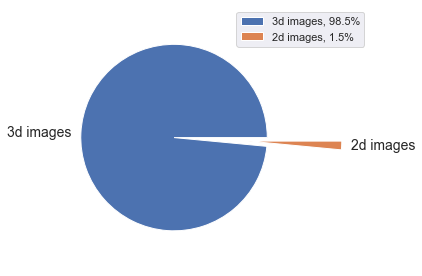

However, it is clear that the images are mostly 3d.


In [158]:
# Find all the number of images with no 3rd dimension
labels = ['3d images','2d images']
all_images = dict(Counter([i[2] for i in image_dimensions_3d]))
plt.pie(labels=labels, x=list(all_images.values()),explode=[0,0.8], textprops={'fontsize': 14})
labels = [f'{l}, {s/10:0.1f}%' for l, s in zip(labels, list(all_images.values()))]

plt.legend(labels, loc='best')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("However, it is clear that the images are mostly 3d.")

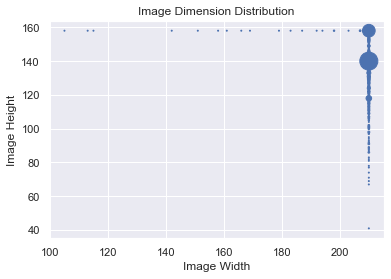

Top 3 dimensions out of 1000 images
{'(210, 140)': 325, '(210, 158)': 160, '(210, 139)': 52}


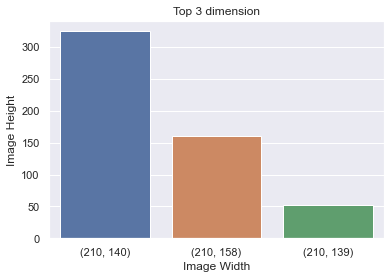

We see that a significant portion of images are 210 x 140 (weight x height), however, there would be a need to standardise the image data     input to ensure through an image function that biasedness towards predicting a boat type through the image type is     not learnt by the model


In [219]:
plt.scatter(
            x = [i[0] for i in image_shape_distribution.keys()], # Width 
            y = [i[1] for i in image_shape_distribution.keys()], # Height
            s = list(image_shape_distribution.values())           # Count
            )
plt.title("Image Dimension Distribution")
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

top_3_dimension = sorted(image_shape_distribution, key=image_shape_distribution.get, reverse=True)[:3]
sns.barplot(x = [str(i) for i in top_3_dimension], y= [image_shape_distribution[i] for i in top_3_dimension])
print("Top 3 dimensions out of {} images".format(TRAIN_SAMPLES))
print(dict(zip([str(i) for i in top_3_dimension],[image_shape_distribution[i] for i in top_3_dimension])))
plt.title("Top 3 dimension")
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.show()

print("We see that a significant portion of images are 210 x 140 (weight x height), however, there would be a need to standardise the image data \
    input to ensure through an image function that biasedness towards predicting a boat type through the image type is \
    not learnt by the model")